In [1]:
%%capture
## compile PyRoss for this notebook
import os
owd = os.getcwd()
os.chdir('../../')
%run setup.py install
os.chdir(owd)

In [2]:
%matplotlib inline
import numpy as np
import pyross
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
#from matplotlib import rc; rc('text', usetex=True)

In [15]:
M = 2                # the population has two age groups
N = 5e4              # and this is the total population

# set the age structure
fi = np.array([0.25, 0.75])  # fraction of population in age age group
Ni = N*fi

# set the contact structure
C = np.array([[18., 9.], [3., 12.]])


def contactMatrix(t):   
    return C

# duration of simulation and data file
Tf = 100;  
Nt=Tf+1; 

beta = 0.02
alpha = 0.2
gIa = 1/7 
gIs = 1/7 
fsa = 1


# set up initial condition
Ia0 = np.array([20, 20])  # each age group has asymptomatic infectives
Is0 = np.array([20, 20])  # and also symptomatic infectives
R0  = np.array([0, 0])    # there are no recovered individuals initially
S0  = Ni - (Ia0 + Is0 + R0)

Tf = 100
Nf = Tf+1

def contactMatrix(t):
    return C

parameters = {'alpha':alpha, 'beta':beta, 'gIa':gIa, 'gIs':gIs,'fsa':fsa}
true_parameters = {'alpha':alpha, 'beta':beta, 'gIa':gIa, 'gIs':gIs,'fsa':fsa}

# use pyross stochastic to generate traj and save 
sto_model = pyross.stochastic.SIR(parameters, M, Ni)
data = sto_model.simulate(S0, Ia0, Is0, contactMatrix, Tf, Nf)
data_array = data['X']

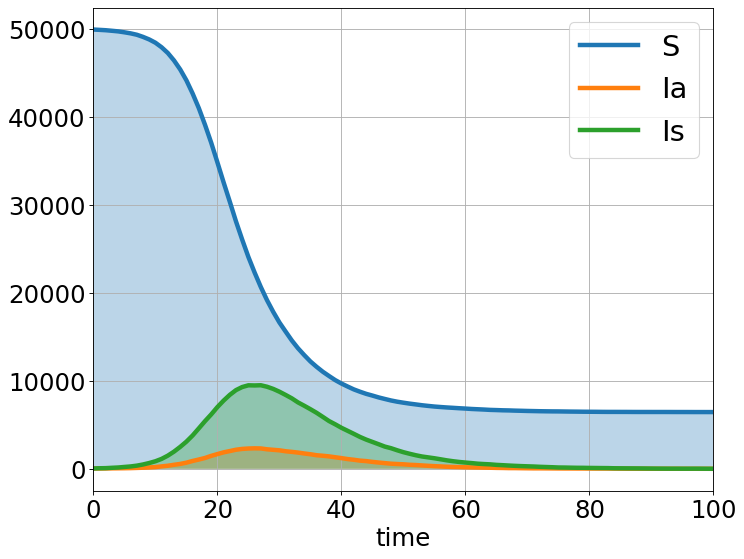

In [16]:
fig = plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 22})
t = data['t']

plt.fill_between(t, 0, np.sum(data_array[:, :M], axis=1),  alpha=0.3)
plt.plot(t, np.sum(data_array[:, :M], axis=1), '-', label='S', lw=4)

plt.fill_between(t, 0, np.sum(data_array[:, M:2*M], axis=1), alpha=0.3)
plt.plot(t, np.sum(data_array[:, M:2*M], axis=1), '-', label='Ia', lw=4)

plt.fill_between(t, 0, np.sum(data_array[:, 2*M:3*M], axis=1), alpha=0.3)
plt.plot(t, np.sum(data_array[:, 2*M:3*M], axis=1), '-', label='Is', lw=4)

plt.legend(fontsize=26)
plt.grid() 
plt.xlabel(r'time') 
plt.autoscale(enable=True, axis='x', tight=True)

In [17]:
# load the data and rescale to intensive variables 
Tf_inference = 20 # truncate to only getting the first few datapoints 
Nf_inference = Tf_inference+1
x = (data_array[:Nf_inference]).astype('float')/N 

In [18]:
inference_parameters = {
    'betaIa' : beta*alpha, 
    'betaIs' : beta*(1-alpha), 
    'gIa' : gIa, 
    'gIs' : gIs
}

model_spec = {
    "classes" : ["S", "Ia", "Is"],

    "S" : {
        "infection" : [ ["Ia", "-betaIa"], ["Is", "-betaIa"], ["Ia", "-betaIs"], ["Is", "-betaIs"]]
    },
    "Ia" : {
        "linear"    : [ ["Ia", "-gIa"] ],
        "infection" : [ ["Ia", "betaIa"], ["Is", "betaIa"] ]
    }, 
    "Is" :{
        "linear"    : [ ["Is", "-gIs"] ],
        "infection" : [ ["Is", "betaIs"], ["Ia", "betaIs"]]
    }
}

In [19]:
# a filter that sums over all the infected people for each age group
fltr = np.kron([0, 1, 1],np.identity(M))
print(fltr)

# Compare the deterministic trajectory and the stochastic trajectory with the same 
# initial conditions and parameters 
obs=np.einsum('ij,kj->ki', fltr, x)
x0=x[0]

# initialise the estimator 
steps = 4 # number internal integration steps taken
estimator = pyross.inference.Spp(model_spec, inference_parameters, M, fi, N, steps, lyapunov_method='euler')

# compute -log_p for the original (correct) parameters 
logp = estimator.minus_logp_red(inference_parameters, x0, obs[1:], fltr, Tf_inference, Nf_inference, contactMatrix)
print(logp) 

[[0. 0. 1. 0. 1. 0.]
 [0. 0. 0. 1. 0. 1.]]
-263.9404507446058


In [20]:
# make parameter guesses and set up bounds for each parameter 
eps=1e-4

betaIs_g = 0.02
betaIs_std = 0.02
betaIs_b = (eps, 0.1)

betaIa_g = 0.005
betaIa_std = 0.003 
betaIa_b = (eps, 0.1)

gIa_g = 0.2
gIa_std = 0.1 
gIa_b = (eps, 1)

gIs_g = 0.2
gIs_std = 0.1 
gIs_b = (eps, 1) 


Ia0_g = (Ia0+3)/N
Ia_std = Ia0_g*0.4 
bounds_for_Ia = np.tile([0.1/N, 100/N], M).reshape(M, 2)

S0_g = (S0-3)/N
S_std = Ia_std*np.sqrt(3)
bounds_for_S = np.array([(1/N, f-1/N) for f in fi]).reshape(M, 2)

# optimisation parameters 
ftol = 1e-5 # the relative tol in (-logp)  

# set up bounds, guess and stds for the rest of the params 
keys = ['betaIa', 'betaIs', 'gIa', 'gIs']
bounds = np.array([betaIa_b, betaIs_b, gIa_b, gIs_b, 
                   *bounds_for_S, *bounds_for_Ia])
guess = np.array([betaIa_g, betaIs_g, gIa_g, gIs_g, *S0_g, *Ia0_g])
stds = np.array([betaIa_std, betaIs_std, gIa_std, gIs_std, *S_std, *Ia_std])

# set up fltr for initial conditions because they are constraint by the observed 
init_fltr = np.repeat([True, True, False], M)


params = estimator.latent_infer_parameters(keys, init_fltr, guess, stds, obs, fltr, Tf_inference, Nf_inference, 
                                    contactMatrix, bounds, 
                                    global_max_iter=10, global_ftol_factor=1e3, 
                                    verbose=True, ftol=ftol) 

Starting global minimisation...
(8_w,16)-aCMA-ES (mu_w=4.8,w_1=32%) in dimension 8 (seed=2094200397, Wed May 27 11:31:14 2020)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     16 -2.283931958998048e+02 1.0e+00 9.72e-01  2e-04  1e-01 0:00.8
    2     32 -2.693278081741235e+02 1.3e+00 9.72e-01  2e-04  9e-02 0:01.5
    3     48 -6.116771594391025e+00 1.4e+00 1.11e+00  2e-04  1e-01 0:02.2
    8    128 -1.993291811873052e+02 2.5e+00 1.44e+00  2e-04  1e-01 0:05.4
Optimal value (global minimisation):  -299.1622585586803
Starting local minimisation...
Optimal value (local minimisation):  -306.46314884096745


In [21]:
print("True parameters:")
print(inference_parameters)

print("\nInferred parameters:")
best_estimates = estimator.fill_params_dict(keys, params)
print(best_estimates)

True parameters:
{'betaIa': 0.004, 'betaIs': 0.016, 'gIa': 0.14285714285714285, 'gIs': 0.14285714285714285}

Inferred parameters:
{'betaIa': 0.005491131698019096, 'betaIs': 0.015219305376642003, 'gIa': 0.16329895420477605, 'gIs': 0.14411833847439343}


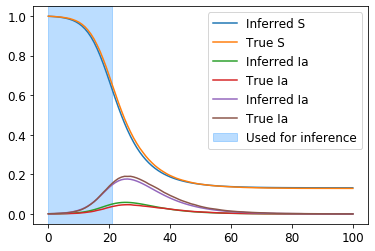

In [22]:
Nf = 101
Tf = Nf-1

partial_inits = params[len(keys):]
x0 = estimator.fill_initial_conditions(partial_inits, obs[0], init_fltr, fltr)

model = pyross.deterministic.Spp(model_spec, best_estimates, int(M), fi)
det_data = model.simulate(x0, contactMatrix, Tf, Nf)
x_det = det_data['X']
x = data['X']/N
plt.rcParams.update({'font.size': 12})
plt.plot(np.sum(x_det[:, :M], axis=1), label='Inferred S')
plt.plot(np.sum(x[:, :M], axis=1), label='True S')
plt.plot(np.sum(x_det[:, M:2*M], axis=1), label='Inferred Ia')
plt.plot(np.sum(x[:, M:2*M], axis=1), label='True Ia')
plt.plot(np.sum(x_det[:, 2*M:3*M], axis=1), label='Inferred Ia')
plt.plot(np.sum(x[:, 2*M:3*M], axis=1), label='True Ia')
plt.axvspan(0, Nf_inference, 
           label='Used for inference',
           alpha=0.3, color='dodgerblue')
plt.legend()
plt.show() 